<h1 align="center"> 🍎 Redes Neuronales Convolucionales con Fruits 360 🍎</h1>

## Instalamos la API de Kaggle

Para evitar la descarga local del archivo, realizaremos unos pasos aprovechando la API de Kaggle

In [2]:
!pip install -q kaggle
!mkdir -p ~/.kaggle

Importamos el `kaggle.json` con `google.colab`

In [ ]:
from google.colab import files
files.upload()

In [4]:
!cp kaggle.json ~/.kaggle/ # Para que el archivo .json quede en la carpeta adecuada para ser leída durante la descarga de datos

## Descargamos el Dataset de Fruits 
 
Descargamos y Descomprimimos el dataset que está comprimido 

In [5]:
!kaggle datasets download -d moltean/fruits --force

100% 1.28G/1.28G [00:22<00:00, 69.1MB/s]
100% 1.28G/1.28G [00:22<00:00, 61.7MB/s]


In [6]:
!unzip /content/fruits.zip -d fruits-360

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: fruits-360/fruits-360_dataset/fruits-360/Training/Tomato 3/111_100.jpg  
  inflating: fruits-360/fruits-360_dataset/fruits-360/Training/Tomato 3/112_100.jpg  
  inflating: fruits-360/fruits-360_dataset/fruits-360/Training/Tomato 3/113_100.jpg  
  inflating: fruits-360/fruits-360_dataset/fruits-360/Training/Tomato 3/114_100.jpg  
  inflating: fruits-360/fruits-360_dataset/fruits-360/Training/Tomato 3/115_100.jpg  
  inflating: fruits-360/fruits-360_dataset/fruits-360/Training/Tomato 3/116_100.jpg  
  inflating: fruits-360/fruits-360_dataset/fruits-360/Training/Tomato 3/117_100.jpg  
  inflating: fruits-360/fruits-360_dataset/fruits-360/Training/Tomato 3/119_100.jpg  
  inflating: fruits-360/fruits-360_dataset/fruits-360/Training/Tomato 3/120_100.jpg  
  inflating: fruits-360/fruits-360_dataset/fruits-360/Training/Tomato 3/121_100.jpg  
  inflating: fruits-360/fruits-360_dataset/fruits-360/Training/Tomato 3/122_100

# Importamos las Librerías Necesarias

In [7]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.optimizers import *
from keras.utils import np_utils
from sklearn.datasets import load_files

import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

## Preparamos los datos para trabajar 

In [8]:
TRAIN_PATH = "/content/fruits-360/fruits-360-original-size/fruits-360-original-size/Training/"
TEST_PATH = "/content/fruits-360/fruits-360-original-size/fruits-360-original-size/Test/"
VAL_PATH = "/content/fruits-360/fruits-360-original-size/fruits-360-original-size/Validation/"

<h1 align="center"> Exploración y Análisis de los datos </h1>

> La exploración de datos no es necesario para entrenar el modelo pero es una buena práctica mirar el conjunto de datos que vamos a analizar sobre qué tipos de datos estamos usando y cómo podemos manejarlos.

## Algunas imágenes de ejemplo

(255, 300, 3)


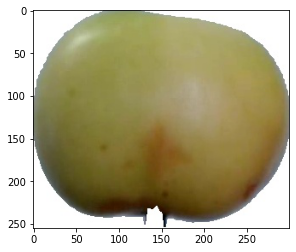

In [9]:
img = mpimg.imread(TRAIN_PATH + 'apple_6/r0_100.jpg')
print(img.shape)
plt.imshow(img);

(663, 186, 3)


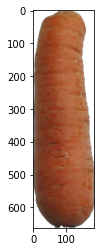

In [10]:
img = mpimg.imread(TRAIN_PATH +'carrot_1/r0_106.jpg')
print(img.shape)
plt.imshow(img);

(1033, 287, 3)


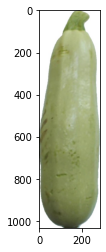

In [11]:
img = mpimg.imread(TRAIN_PATH +'zucchini_1/r0_146.jpg')
print(img.shape)
plt.imshow(img);

# Entrenamiento y Prueba de la información 



In [12]:
import os, os.path
train_categories = []
train_samples = []
for i in os.listdir(TRAIN_PATH):
    train_categories.append(i)
    train_samples.append(len(os.listdir(TRAIN_PATH + i)))

test_categories = []
test_samples = []
for i in os.listdir(TEST_PATH):
    test_categories.append(i)
    test_samples.append(len(os.listdir(TEST_PATH + i)))

    
print("La cantidad de Frutas en el Conjunto de Entrenamiento:", sum(train_samples))
print("La cantidad de Frutas en el Conjunto de Prueba:", sum(test_samples))

La cantidad de Frutas en el Conjunto de Entrenamiento: 6231
La cantidad de Frutas en el Conjunto de Prueba: 3110


## Distribución de Frutas con el Conjunto de Entrenamiento

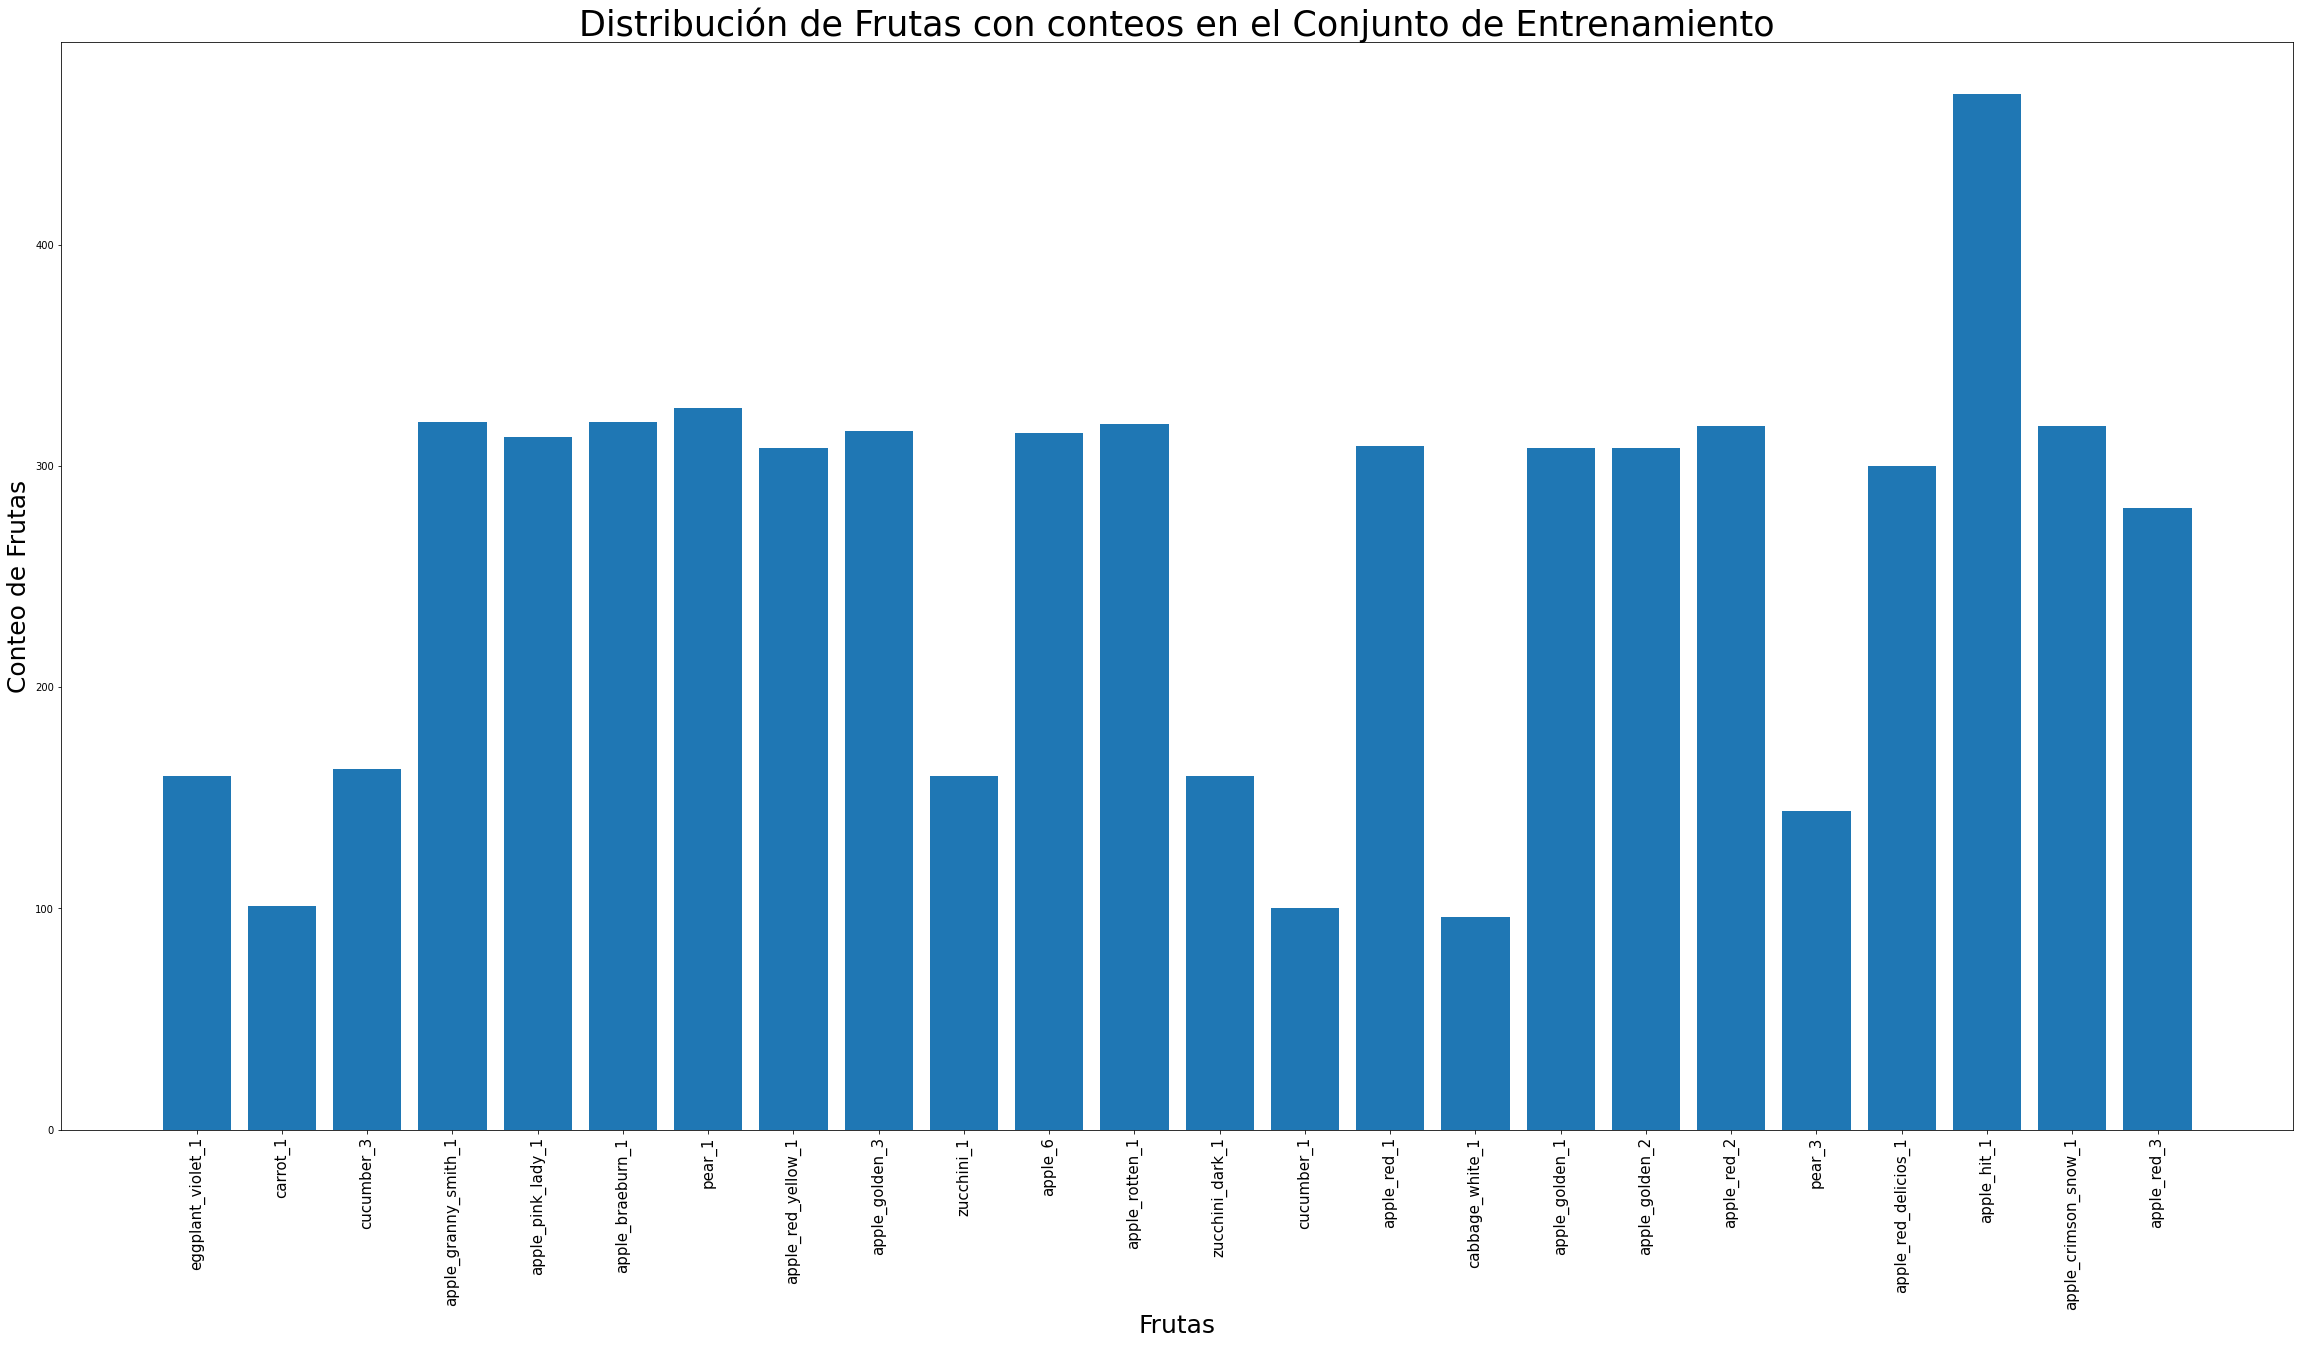

In [13]:
figure_size = plt.rcParams["figure.figsize"]
figure_size[0] = 40
figure_size[1] = 20
plt.rcParams["figure.figsize"] = figure_size
index = np.arange(len(train_categories))
plt.bar(index, train_samples)
plt.xlabel('Frutas', fontsize=25)
plt.ylabel('Conteo de Frutas', fontsize=25)
plt.xticks(index, train_categories, fontsize=15, rotation=90)
plt.title('Distribución de Frutas con conteos en el Conjunto de Entrenamiento', fontsize=35)
plt.show()

## Distribución de Frutas con el Conjunto de Prueba

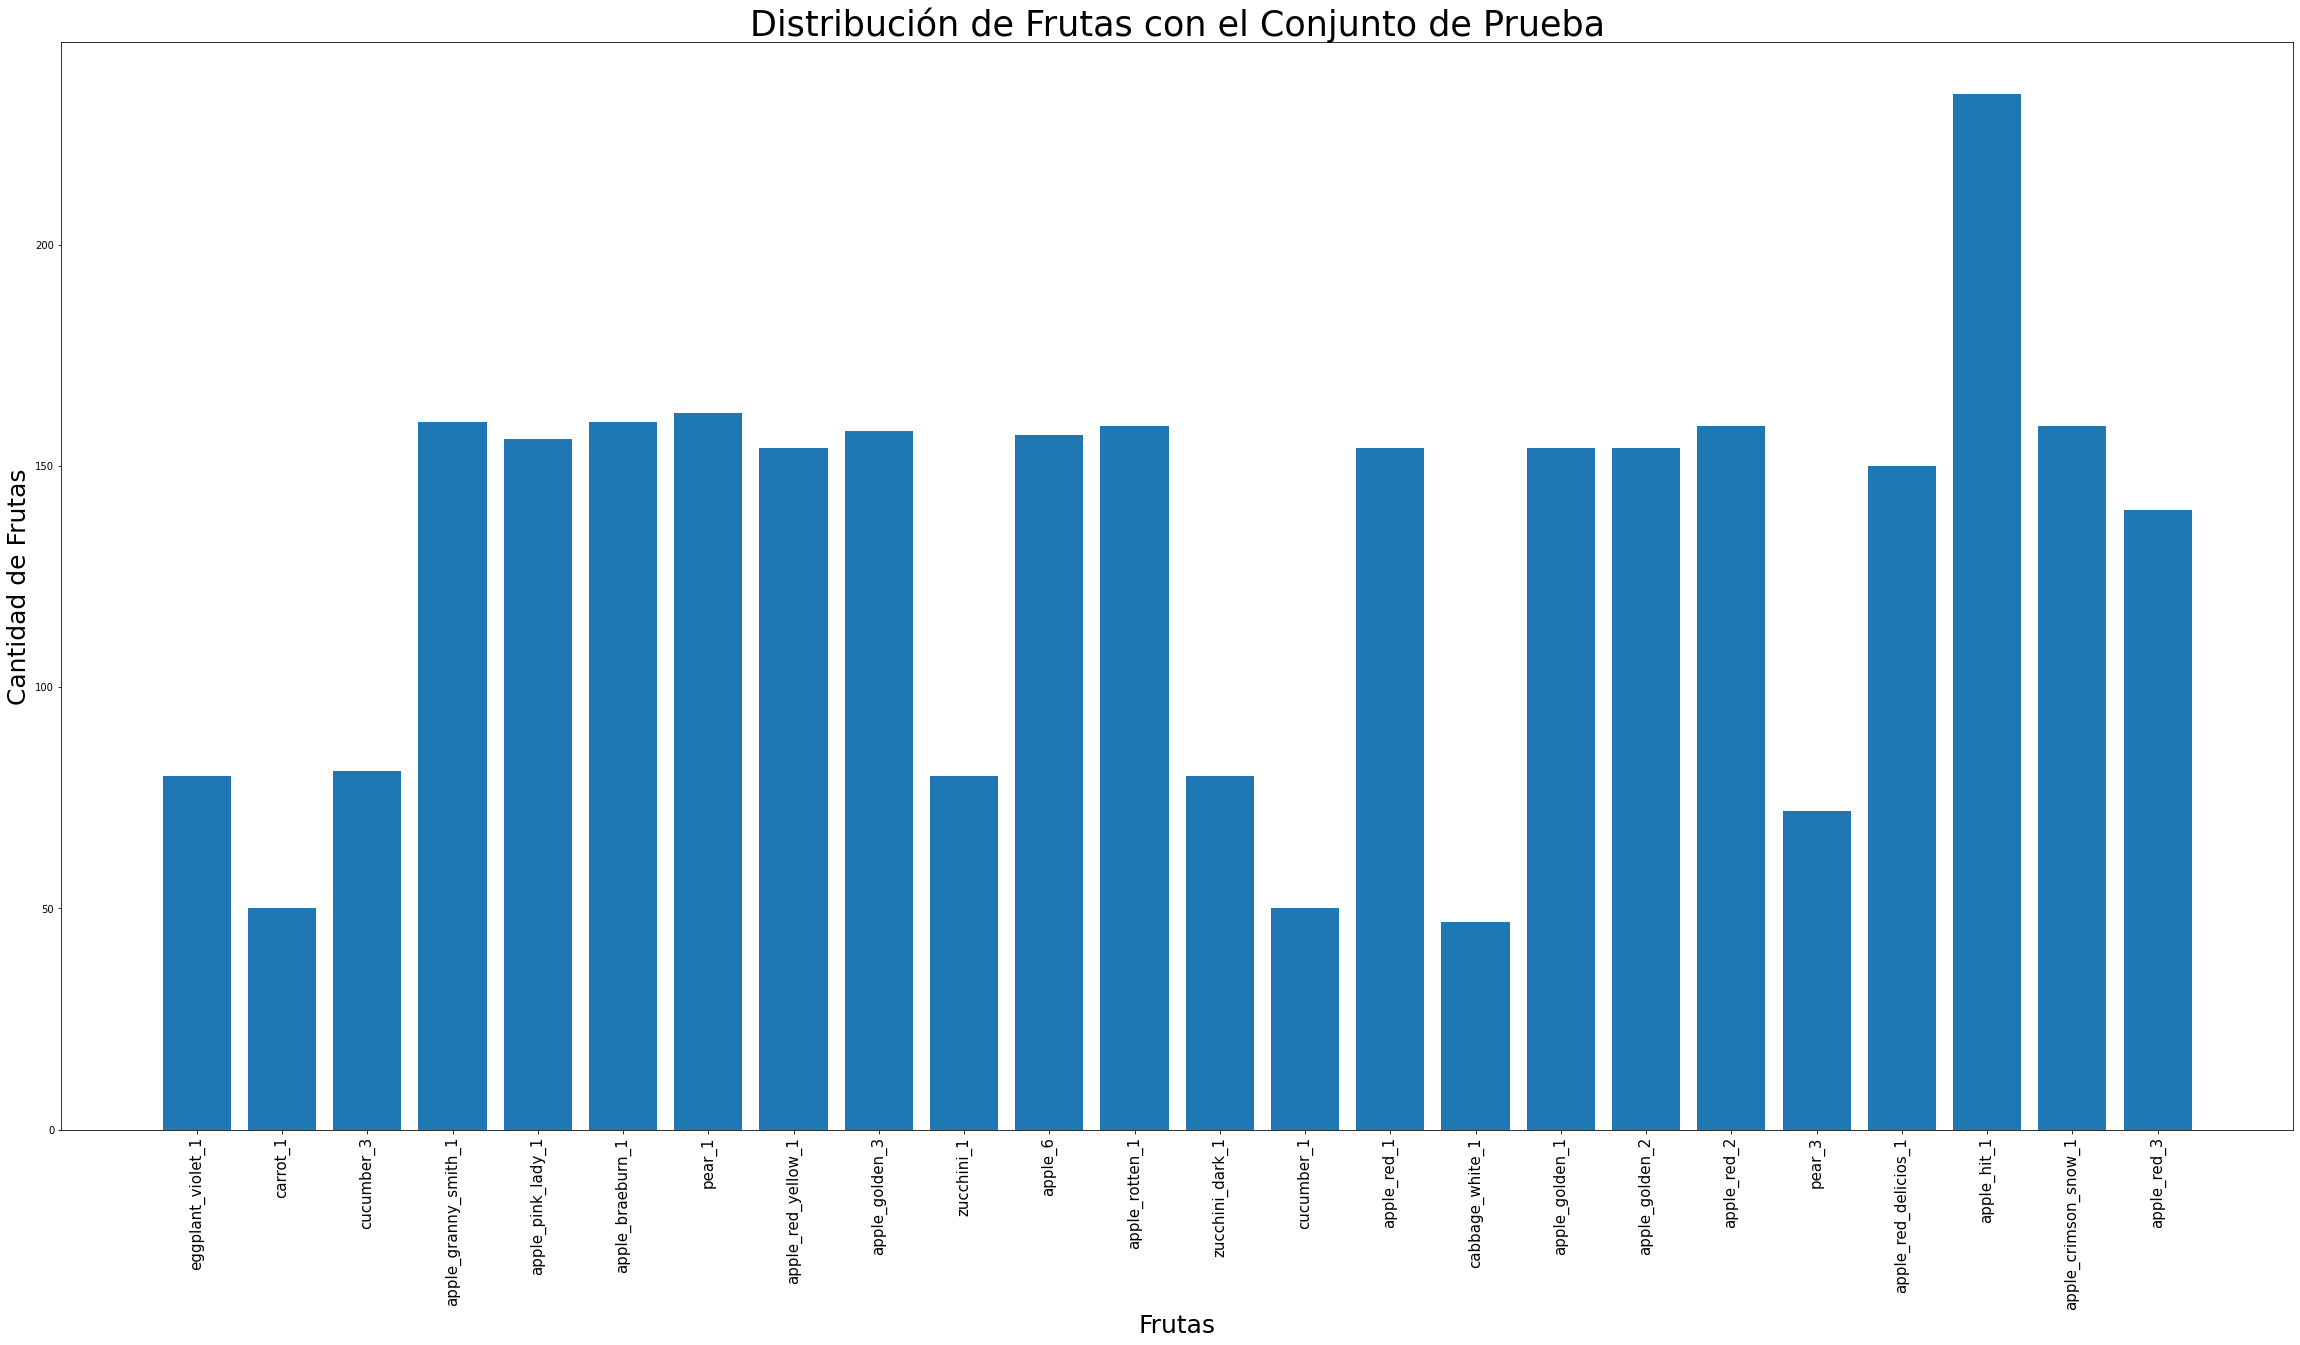

In [14]:
index2 = np.arange(len(test_categories))
plt.bar(index2, test_samples)
plt.xlabel('Frutas', fontsize=25)
plt.ylabel('Cantidad de Frutas', fontsize=25)
plt.xticks(index2, test_categories, fontsize=15, rotation=90)
plt.title('Distribución de Frutas con el Conjunto de Prueba', fontsize=35)
plt.show()

# Procesamiento de los datos

## Cargamos los datos y dividimos el conjunto de datos en entrenamiento y de prueba con nombres de las etiquetas

>- Estamos cargando todos los datos de entrenamiento (train) y prueba (test)
>- Guardamos entradas/imágenes en **X_train** de datos de entrenamiento y guardar etiquetas en **Y_train**
>- Guardamos entradas/imágenes en **X_test** de datos de prueba y guardar etiquetas en **Y_test**

In [15]:
def load_dataset(data_path):
    data_loading = load_files(data_path)
    files_add = np.array(data_loading['filenames'])
    targets_fruits = np.array(data_loading['target'])
    target_labels_fruits = np.array(data_loading['target_names'])
    return files_add,targets_fruits,target_labels_fruits
    
X_train, Y_train, target_labels = load_dataset(TRAIN_PATH)
X_test, Y_test, target_labels = load_dataset(TEST_PATH)
X_val, Y_val, target_labels = load_dataset(VAL_PATH)

print('Cantidad de Datos de Entrenamiento: ' , X_train.shape[0])
print('Cantidad de Datos de Validación: ' , X_val.shape[0])
print('Cantidad de Datos de Test: ', X_test.shape[0])
print("Las clases de frutas son: \n", target_labels)

Cantidad de Datos de Entrenamiento:  6231
Cantidad de Datos de Validación:  3114
Cantidad de Datos de Test:  3110
Las clases de frutas son: 
 ['apple_6' 'apple_braeburn_1' 'apple_crimson_snow_1' 'apple_golden_1'
 'apple_golden_2' 'apple_golden_3' 'apple_granny_smith_1' 'apple_hit_1'
 'apple_pink_lady_1' 'apple_red_1' 'apple_red_2' 'apple_red_3'
 'apple_red_delicios_1' 'apple_red_yellow_1' 'apple_rotten_1'
 'cabbage_white_1' 'carrot_1' 'cucumber_1' 'cucumber_3'
 'eggplant_violet_1' 'pear_1' 'pear_3' 'zucchini_1' 'zucchini_dark_1']


## Clases de frutas

> Hay 24  etiquetas/clases que son los nombres de frutas ya que estamos usando  de 24 tipos de frutas.

In [16]:
num_classes = len(np.unique(Y_train))
print(f"La cantidad de clases de frutas son: {num_classes}")

La cantidad de clases de frutas son: 24


## Limpieza de datos
>Vector del primer registro de Y_train:
> - Como sabemos que estamos usando 24 clases/etiquetas, creamos un vector de 24 valores. 
> - Podemos ver que solo hay 1 y todos son ceros que muestra una label de la primera imagen.

In [17]:
Y_train = np_utils.to_categorical(Y_train, num_classes)
Y_test = np_utils.to_categorical(Y_test, num_classes)
# Standariza los datos de las dimensiones que tenemos con las 24 posibles opciones 

In [18]:
Y_train[0] #Ejemplo de la imagen de la posicion 0

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)

## Dividimos el conjunto de validación con el en conjunto de prueba y de validación.

>- Los **datos de validación** se usarán mientras se entrena el modelo para comprobar el rendimiento durante el entrenamiento
>
>- Los **datos de prueba** se usarán después de entrenar el modelo.

In [19]:
print (f"Los datos de la Validacion son X_val: {X_val.shape} y de Y_val: {Y_val.shape}")
print (f"Los datos del Test son X_test: {X_test.shape} y de Y_test: {Y_test.shape}")

Los datos de la Validacion son X_val: (3114,) y de Y_val: (3114,)
Los datos del Test son X_test: (3110,) y de Y_test: (3110, 24)



# Procesamiento de la Imagen

> Definimos como variables globales al número de clases, el ancho y largo de largo de las imágenes y el tamaño de filtro que vamos a utilizar.

In [20]:
NUM_CLASS = num_classes # 24 clases 
IMG_H, IMG_W = 100, 100 
BATCH_SIZE = 32

## Data Augmentation

> Usamos el Data Augmentation para tener la imagen con distintas caracteristicas sin modificar el dato. 
> Es dificil obtener y clasificar las imagenes para entrenar nuestro modelo.
> El Data Augmentation, mantiene las caracteristicas de la imagen y genera otra con otras caracteristicas. Los espacios negros se arregla con `fill_mode()`.



In [21]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    fill_mode="nearest",
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_H, IMG_W),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
)

val_generator = val_datagen.flow_from_directory(
    VAL_PATH,
    target_size=(IMG_H, IMG_W),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
)

Found 6231 images belonging to 24 classes.
Found 3114 images belonging to 24 classes.


<h1 align="center"> Creando nuestra red neuronal <h1>

Ahora, comencemos con nuestro primer enfoque que utiliza redes neuronales convolucionales personalizadas. 

Las CNN son técnicas asombrosas que ayudan a una red neuronal a aprender características espaciales y relacionadas. 

Las CNN ayudan a la red neuronal a aprender las relaciones entre varias áreas de una imagen, como bordes, ojos, etc.

Cuanto más profunda es la red neuronal, más características complejas se aprenden.

- Llamamos al modelo **secuencial** para hacer el entrenamiento y para un mayor ajuste de párametros en datos de imagen.

- **Batch normalization** aplica una transformación que mantiene la salida media cercana a 0 y la desviación estándar de salida cercana a 1.

- **Conv2D** es una capa convolucional 2D (donde los filtros se aplican a la imagen original con un mapa de características específicas para reducir la cantidad de características), la capa Conv2D crea el kernel de convolución (tamaño fijo de cuadros para aplicar en la imagen) que toma de entrada 32 filtros que ayudan a producir un tensor de salidas. Estamos dando entrada de la imagen con un tamaño de 100 de ancho y 100 de alto y 3 es el canal para RGB.

- La función de **activation** es un nodo que se coloca al final de todas las capas del modelo de red neuronal o entre las capas de la red neuronal. La función de activación ayuda a decidir qué neurona debe pasar y qué neurona debe dispararse. Entonces, la función de activación del nodo define la salida de ese nodo dada una entrada o un conjunto de entradas.

- **Maxpooling** opera pixel por pixel y saco el maximo valor del kernel que sería la salida.

- La capa de **Droupout** deja caer algunas neuronas de las capas anteriores. ¿Por qué aplicamos esto? Aplicamos esto para evitar los problemas de sobreajuste. En el sobreajuste, el modelo da una buena precisión en el tiempo de entrenamiento pero no en el tiempo de prueba.

- **Flatten** convierte la matriz 2D en una matriz 1D de todas las características.

- La capa **Dense** reduce las salidas obteniendo entradas de la capa Flatten. La capa Dense usa todas las entradas de las neuronas de la capa anterior y realiza cálculos y envía 24 salidas

 



In [22]:
model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = 3, padding='same', input_shape= (IMG_H, IMG_W, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters = 32, kernel_size = 2))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters = 32, kernel_size = 2, padding='same'))
model.add(Activation('relu'))

model.add(Conv2D(filters = 64, kernel_size = 2))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 128, kernel_size = 2))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(150))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(NUM_CLASS))
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 16)      448       
                                                                 
 activation (Activation)     (None, 100, 100, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 49, 49, 32)        2080      
                                                                 
 activation_1 (Activation)   (None, 49, 49, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                    

<>Compilación de los modelos

- Primero llamamos al modelo

- Estamos usando 24 clases, por lo que establecimos la **pérdida**(lost) como `categorical_crossentropy`. Usamos la **pérdida** como `binary_crossentropy` para dos clases. 

- **Optimizer** es una función que solía cambiar las características de la red neuronal, como la tasa de aprendizaje (cómo aprende el modelo con características) para reducir las pérdidas. Entonces, la tasa de aprendizaje de la red neuronal para reducir las pérdidas está definida por el **optimizer**. 

- Estamos configurando **metrics = accuracy** porque vamos a calcular el porcentaje de predicciones correctas sobre todas las predicciones en el conjunto de validación.


In [23]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 

<h1 align="center">Entrenamiento del modelo con ajuste de parámetros</h1>

> Estamos alimentando los datos de entrenamiento y los datos de validación para comenzar el entrenamiento del modelo. 
> Establecemos los siguientes parámetros:
  - Batch size:  para que el modelo tome 32 imágenes en cada iteración y las entrene. El **batch_size** es un término utilizado en el aprendizaje automatizado y se refiere a la cantidad de ejemplos de entrenamiento utilizados en una iteración. 
  - Epochs = 10 (épocas), por lo que el modelo se entrenará con los datos 10 veces. Época es un término que se usa en el aprendizaje automatizado e indica la cantidad de pasadas del conjunto de datos de entrenamiento completo que ha completado el algoritmo. 
> Podemos elegir el **batch_size** y las **epochs** que queramos, por lo que la buena práctica es establecer algunos valores y entrenar el modelo, si el modelo no da los buenos resultados, podemos cambiarlo y luego intentarlo nuevamente para entrenar rl modelo. 
> Podemos repetir este proceso muchas veces hasta que no obtengamos los buenos resultados y este proceso se denomina **ajuste de parámetros**.

## Callbacks

> - Guarda el mejor entrenamiento previo

In [24]:
checkpoint = ModelCheckpoint("fruits_cnn.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=2)
callbacks = [checkpoint]

## Entrenamiento
> - Guarda el mejor entrenamiento previo 

In [25]:
epochs = 10

history = model.fit(
    train_generator,
    batch_size=32,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_generator,
    verbose=2,
    shuffle=True,
)

Epoch 1/10

Epoch 1: val_loss improved from inf to 1.80139, saving model to fruits_cnn.h5
195/195 - 98s - loss: 2.6674 - accuracy: 0.1395 - val_loss: 1.8014 - val_accuracy: 0.3173 - 98s/epoch - 501ms/step
Epoch 2/10

Epoch 2: val_loss improved from 1.80139 to 0.78636, saving model to fruits_cnn.h5
195/195 - 95s - loss: 1.5539 - accuracy: 0.4336 - val_loss: 0.7864 - val_accuracy: 0.6689 - 95s/epoch - 489ms/step
Epoch 3/10

Epoch 3: val_loss improved from 0.78636 to 0.30922, saving model to fruits_cnn.h5
195/195 - 104s - loss: 0.9417 - accuracy: 0.6492 - val_loss: 0.3092 - val_accuracy: 0.9091 - 104s/epoch - 532ms/step
Epoch 4/10

Epoch 4: val_loss improved from 0.30922 to 0.18875, saving model to fruits_cnn.h5
195/195 - 96s - loss: 0.7008 - accuracy: 0.7291 - val_loss: 0.1888 - val_accuracy: 0.9486 - 96s/epoch - 494ms/step
Epoch 5/10

Epoch 5: val_loss improved from 0.18875 to 0.13579, saving model to fruits_cnn.h5
195/195 - 95s - loss: 0.4874 - accuracy: 0.8183 - val_loss: 0.1358 - val

<h1 align="center">Puntuación de precisión en los datos de prueba</h1>

- La precisión es el número de imágenes reconocidas correctamente de todas las imágenes
- Precisión = Número total de predicciones correctas/Número total de predicciones

In [26]:
model =  tf.keras.models.load_model('/content/fruits_cnn.h5')

test_prec = train_datagen.flow_from_directory(TEST_PATH,target_size=(100,100),shuffle = True)
loss,acc = model.evaluate(test_prec)

Found 3110 images belonging to 24 classes.
98/98 [==============================] - 27s 276ms/step - loss: 0.1953 - accuracy: 0.9289


<h1 align="center">Visualización de la pérdida y precisión con respecto a las épocas</h1>

>Miramos la historia del modelo de cada época mientras entrenamos nuestro modelo en 10 épocas.
>- La línea azul muestra la precisión del entrenamiento y también la pérdida de entrenamiento.
>
> - La línea naranja muestra la precisión de la prueba y también la pérdida de la prueba.
>
> - La precisión y la pérdida en el entrenamiento y los datos de prueba comienzan desde cero y finalmente cerca de 1 (100%).

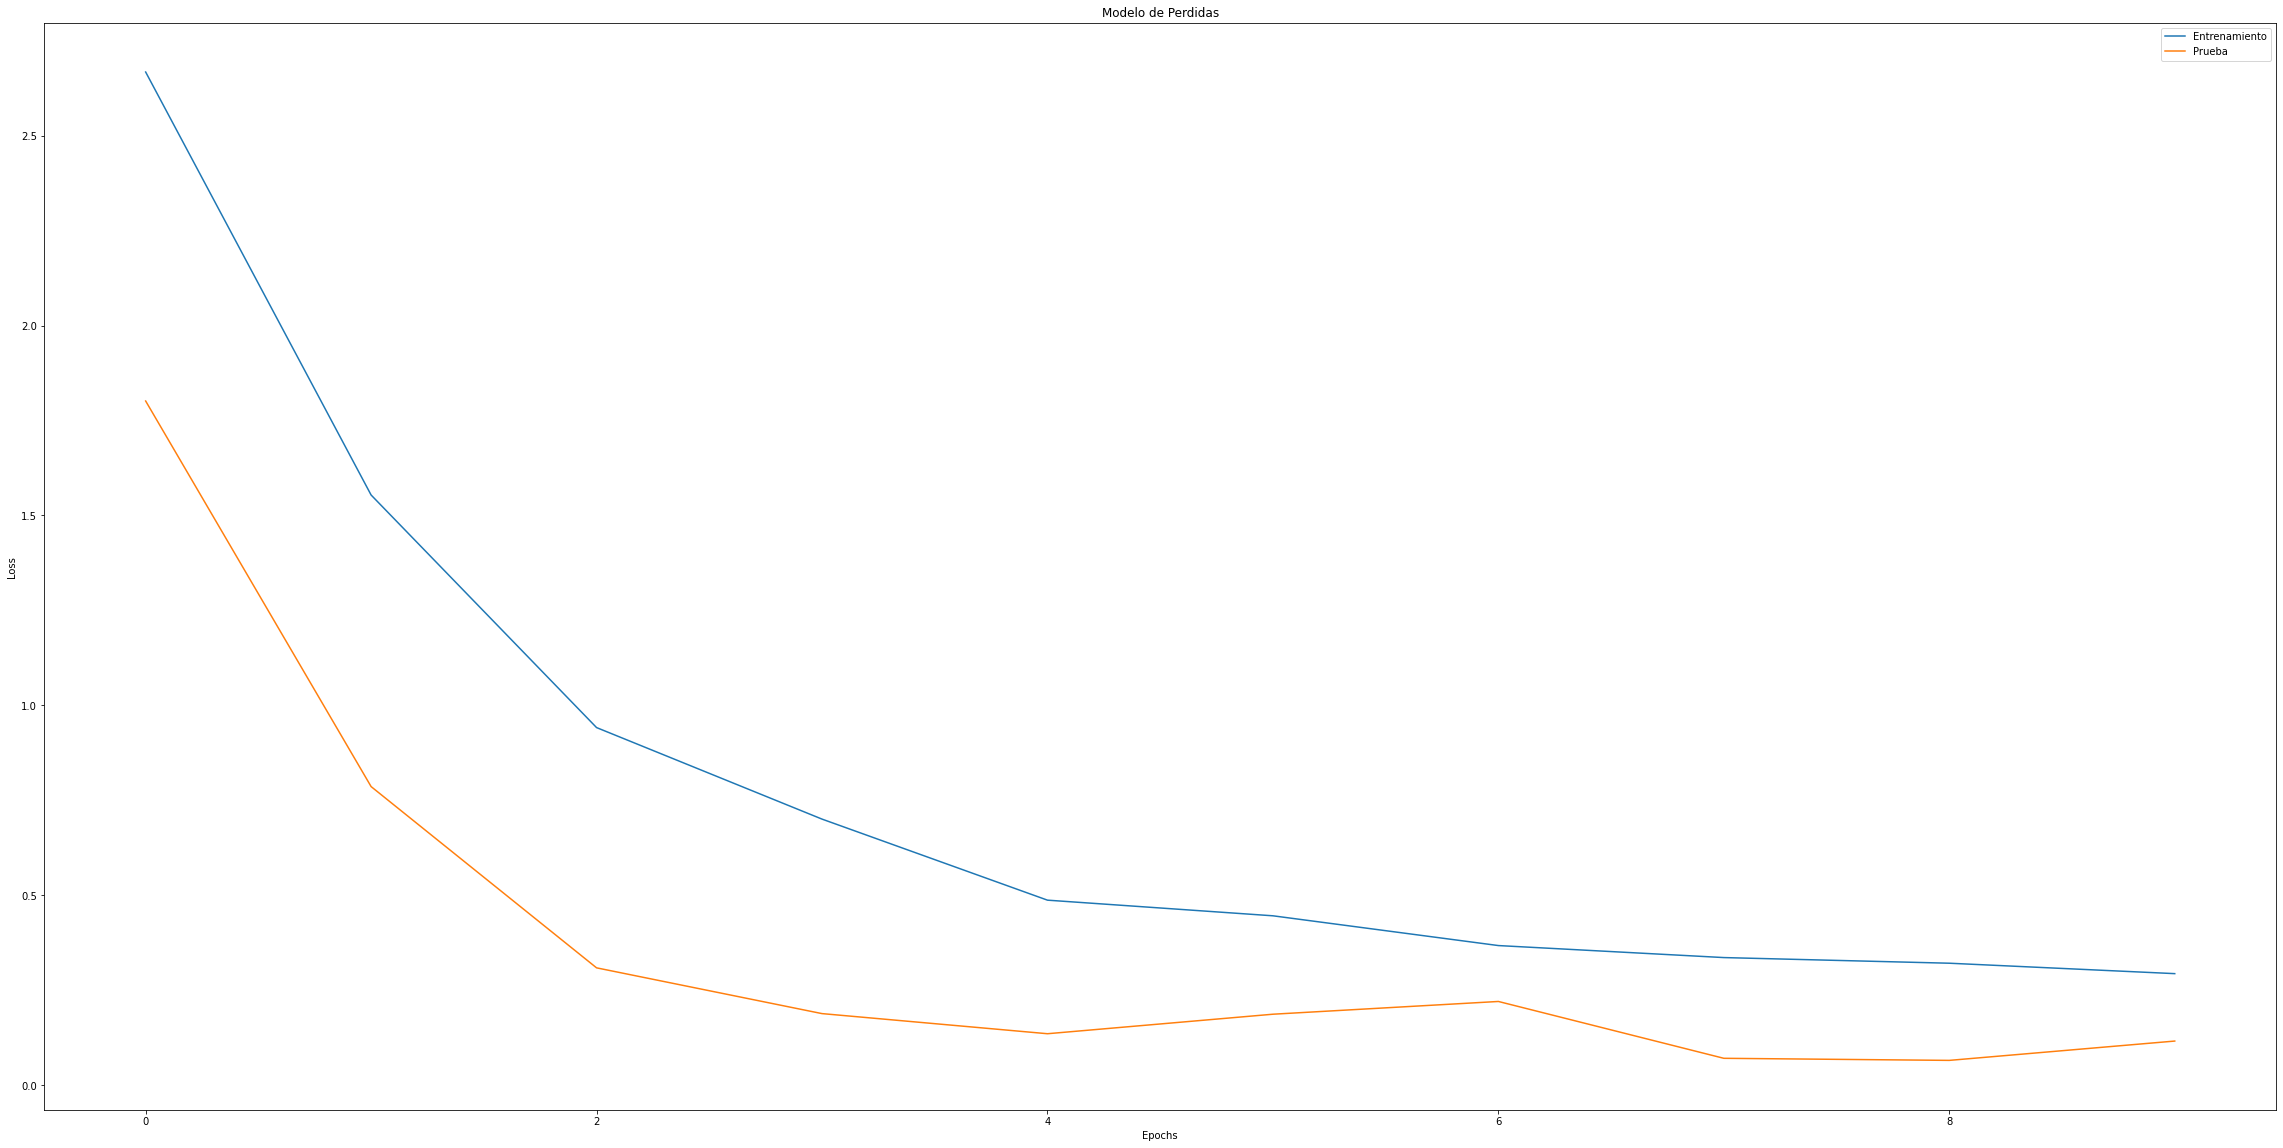

In [27]:
N = epochs

plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"],label="val_loss")
plt.title("Modelo de Perdidas")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Entrenamiento', 'Prueba'])
plt.show();

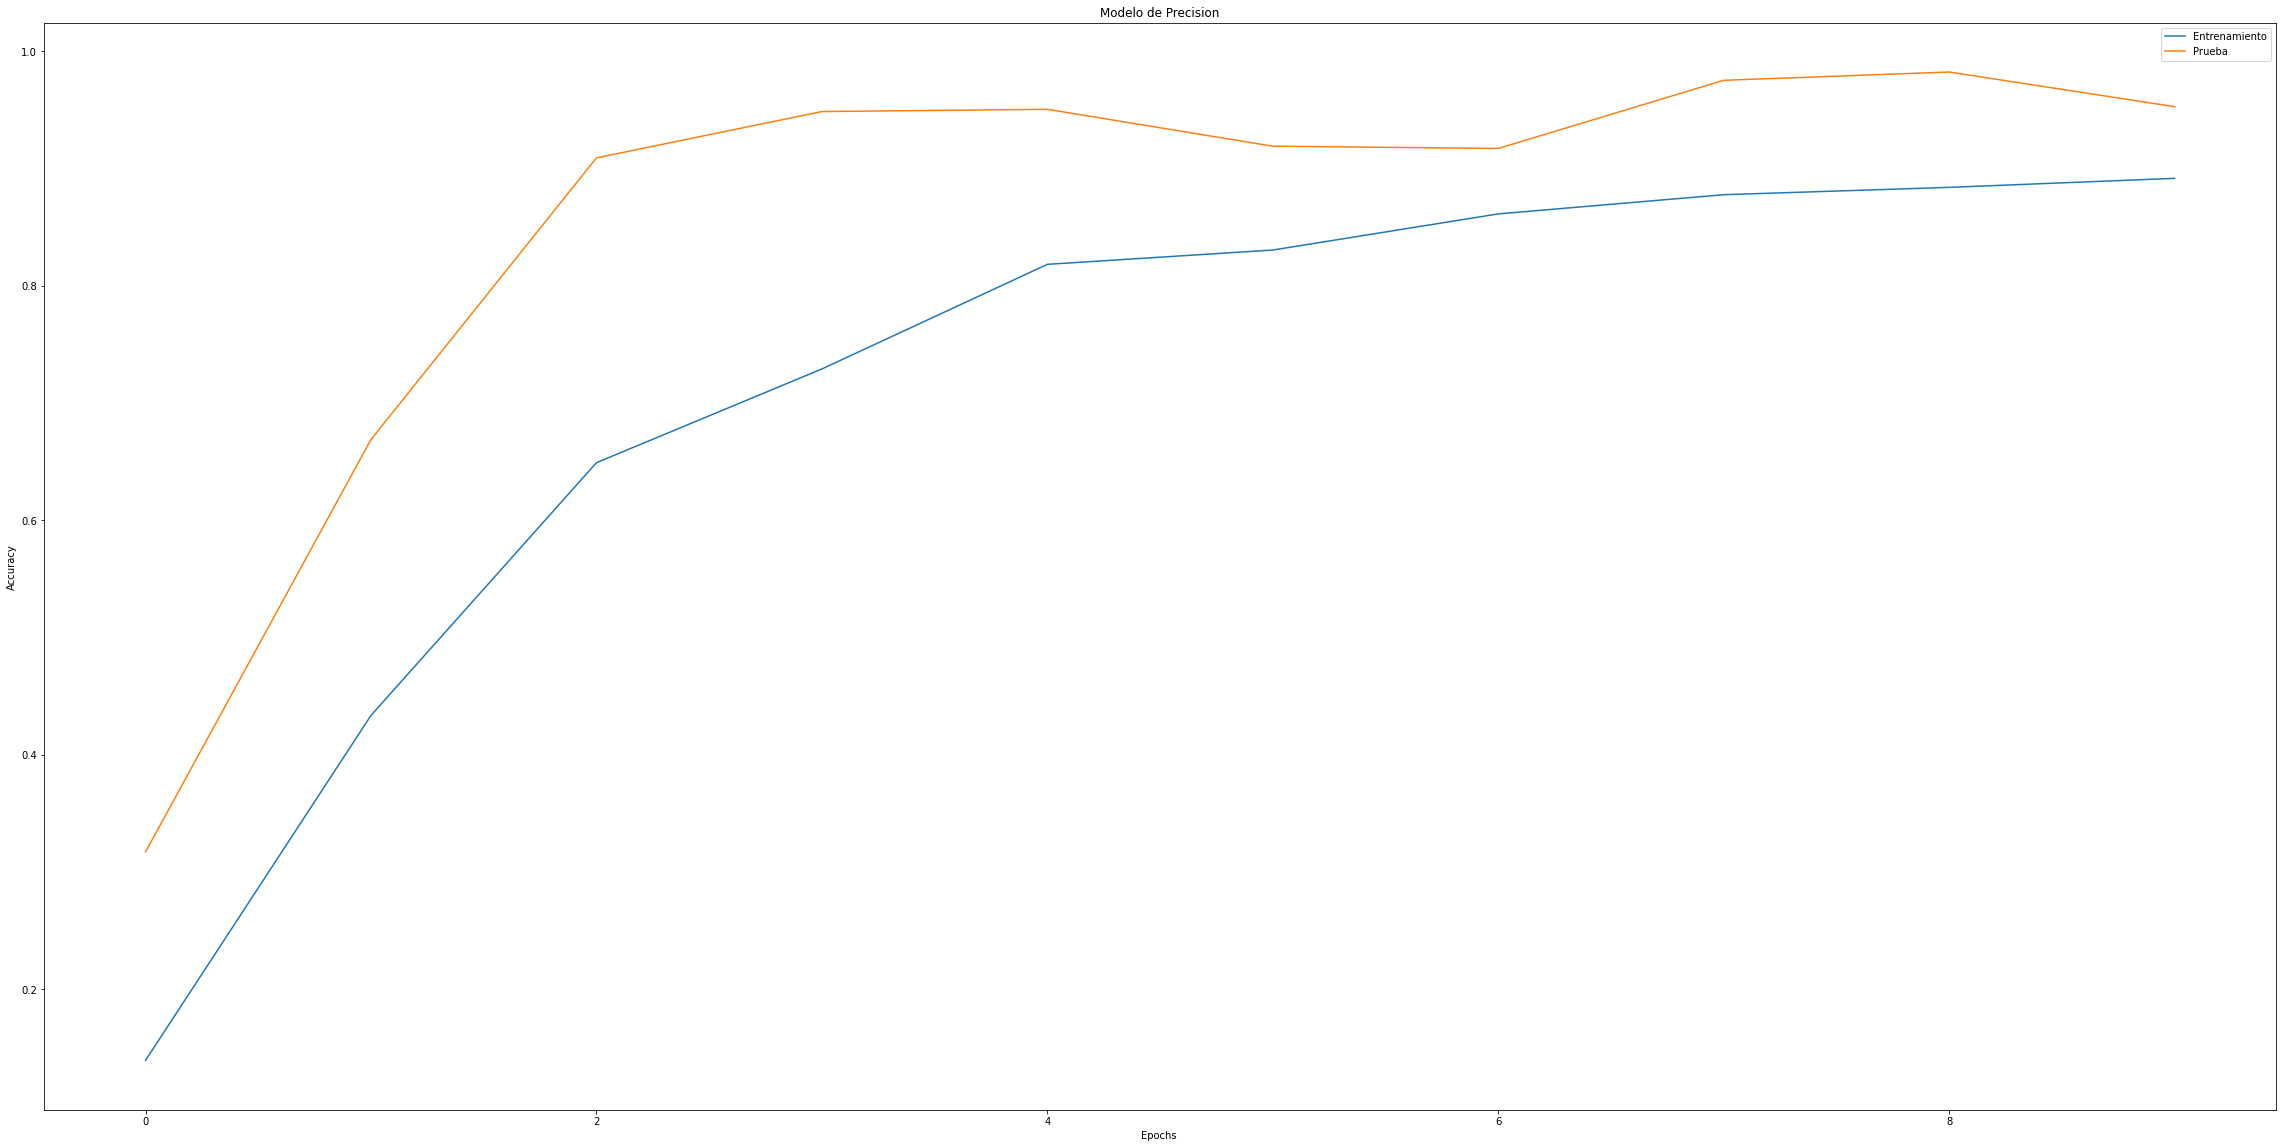

In [28]:
plt.plot(np.arange(0, N), history.history["accuracy"], label="accuracy")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_accuracy")
plt.title("Modelo de Precision")
plt.xlabel("Epochs ")
plt.ylabel("Accuracy")
plt.legend(['Entrenamiento', 'Prueba'])
plt.show();

# Predecir los resultados

- La precisión es el número de imágenes reconocidas correctamente de todas las imágenes.

- Por ejemplo, si el modelo entrenado reconoce 90 imágenes correctas y 10 imágenes incorrectas de un total de 100 imágenes, la puntuación de precisión será del 90 %. 

- Precisión:  0.52526206
- Clase:  apple_red_2 



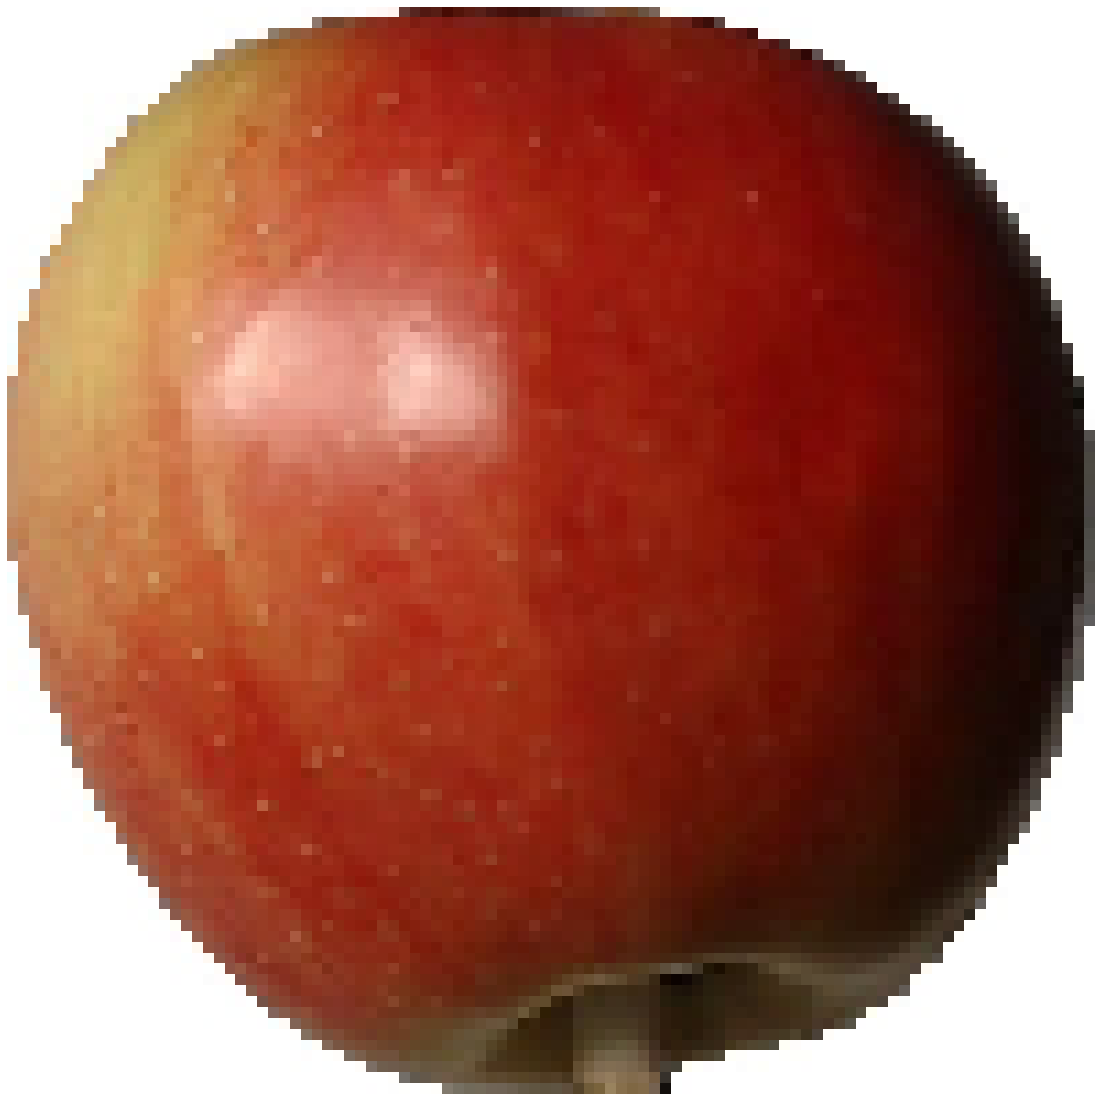

In [29]:
from keras.preprocessing import image

fruitlabel = np.array(target_labels)
test_fruit = image.load_img('/content/fruits-360/fruits-360-original-size/fruits-360-original-size/Test/apple_red_2/r0_143.jpg', target_size = (100,100))
test_fruit = image.img_to_array(test_fruit, dtype=np.uint8)
test_fruit = np.array(test_fruit)/255.0
prediction = model.predict(test_fruit[np.newaxis, ...])

print("- Precisión: ",np.max(prediction[0], axis=-1))
predicted_class = fruitlabel[np.argmax(prediction[0], axis=-1)]
print("- Clase: ",predicted_class,'\n')

plt.axis('off')
plt.imshow(test_fruit.squeeze());

- Precisión:  0.99998355
- Clase:  eggplant_violet_1 



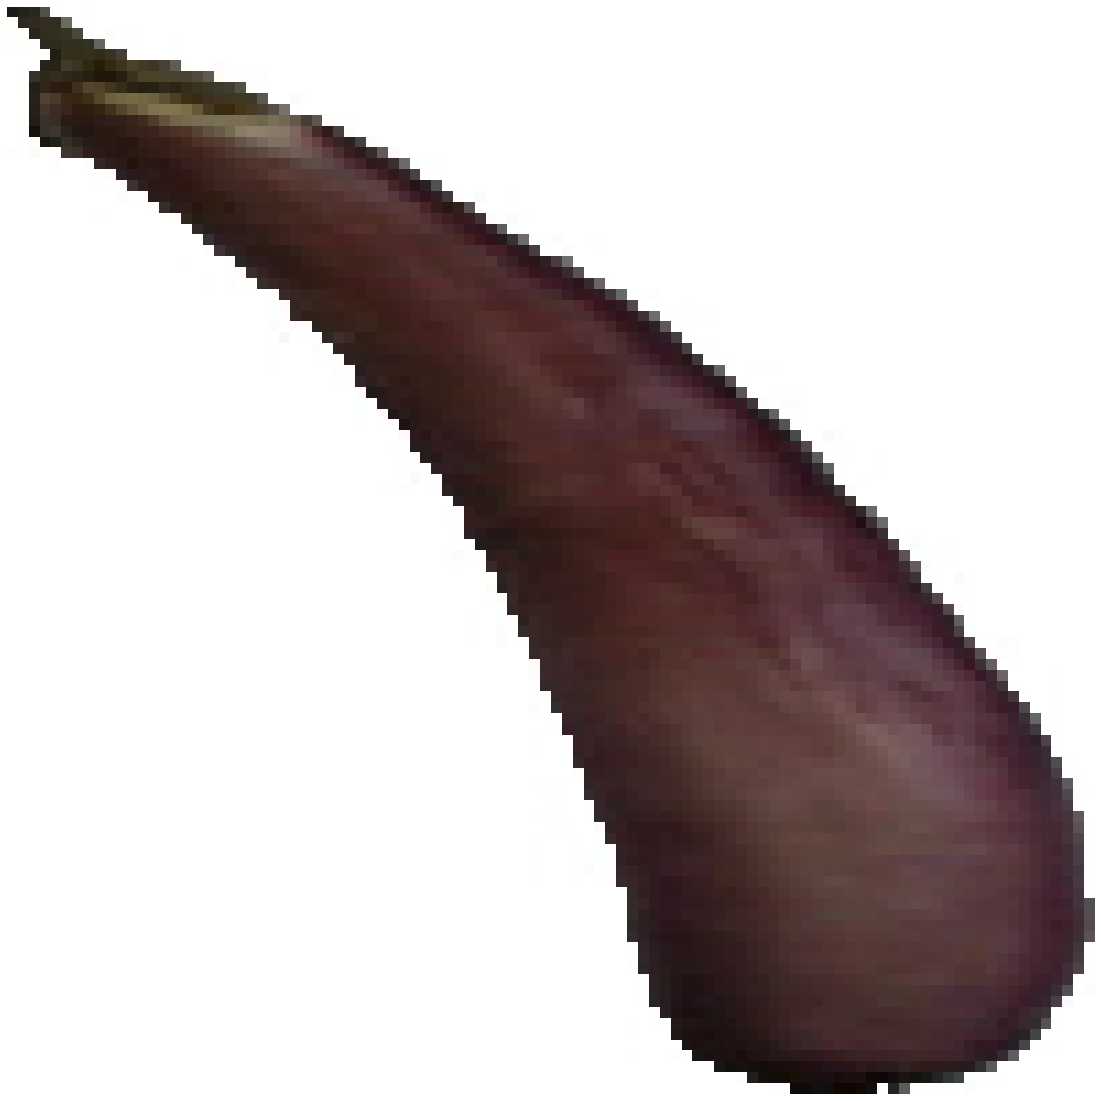

In [30]:
fruitlabel = np.array(target_labels)
test_fruit = image.load_img('/content/fruits-360/fruits-360-original-size/fruits-360-original-size/Test/eggplant_violet_1/r0_107.jpg', target_size = (100,100))
test_fruit = image.img_to_array(test_fruit, dtype=np.uint8)
test_fruit = np.array(test_fruit)/255.0
prediction = model.predict(test_fruit[np.newaxis, ...])

print("- Precisión: ",np.max(prediction[0], axis=-1))
predicted_class = fruitlabel[np.argmax(prediction[0], axis=-1)]
print("- Clase: ",predicted_class,'\n')

plt.axis('off')
plt.imshow(test_fruit.squeeze());

# Conclusión
- Usamos el dataset de Fruits-360 y exploramos los datos de diferentes maneras.
- Preparamos los datos de las imagenes
- Entrenamos el modelo basado en **TensorFlow** con todas sus configuraciones.
- Evaluamos el modelo con precisión y observamos el rendimiento del modelo con gráficos.
- Trabajamos en el problema de clasificación y específicamente lo llamamos clasificación multiclase porque estamos usando en total 24 clases de frutas.

